# Quantifying epistasis with $\Delta\varepsilon_{AI}$

In [1]:
import sys
import numpy as np
import pandas as pd
import pystan
import altair as alt
sys.path.insert(0, '../../')
import mut.thermo
import mut.stats
import mut.bayes
import mut.viz
pboc = mut.viz.altair_config()
alt.renderers.enable('notebook')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


RendererRegistry.enable('notebook')

In [44]:
# Set the binding energy standards. 
ops = {'O2':-13.9, 'O1':-15.3, 'O3':-9.3}

# Load the data
data = pd.read_csv('../../data/csv/compiled_data.csv');

# Prune the data
data = data[(data['fold_change'] > 0) & (data['fold_change'] <= 1.2)]

# Select only the inducer mutants with O2
ind = data[(data['class'] == 'IND') & (data['operator'] == 'O2')].copy()

# Set the identifiers. 
idx_key = {m: int(i + 1) for i, m in enumerate(ind['mutant'].unique())}
idx_recip = {idx_key[i]:i for i in idx_key}
for i, m in enumerate(idx_key.keys()):
    ind.loc[ind['mutant']==m, 'idx'] = idx_key[m]
ind['idx'] = ind['idx'].astype(int)

# Separate data frame for easy sampling. 
leak = ind[ind['IPTGuM']==0]

# Assemble the data dictionary
data_dict = {'J':len(ind['mutant'].unique()), 'N_leak':len(leak), 'N':len(ind),
             'idx_leak':leak['idx'], 'Nns':4.6E6, 'idx':ind['idx'], 'R':260, 'epR':ops['O2'],
            'n_sites':int(2), 'c':ind['IPTGuM'], 'fc_leak':leak['fold_change'],
            'fc':ind['fold_change']}

In [45]:
data.mutant.unique()

array(['wt', 'F164T', 'Q294V', 'Q21M', 'Q21A', 'Q294R', 'Y20I',
       'Q21M-Q294K', 'Q21M-Q294V', 'Q21M-F164T', 'Q21A-F164T',
       'Q21A-Q294K', 'Q21A-Q294V', 'Y20I-F164T', 'Y20I-Q294K',
       'Y20I-Q294V', 'Q294K'], dtype=object)

In [46]:
# Load the stan model. 
model = pystan.StanModel('../stan/hierarchical_inducer_fitting.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00f48d736b9626d6ad2149302087663a NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpa4wijcnt/stanfit4anon_model_00f48d736b9626d6ad2149302087663a_8225894747180579257.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpa4wijcnt/stanfit4anon_model_00f48d736b9626d6ad2149302087663a_8225894747180579257.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [47]:
# Sample the distribution. 
samples = model.sampling(data_dict, iter=10000, chains=4)


/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [48]:
samples_df = mut.bayes.chains_to_dataframe(samples)
rename = {}
for m in samples_df.keys():
    if m != 'logp':
        a, b = m.split('.')
        rename[m] = '{}.{}'.format(a,idx_recip[int(b)])
samples_df.rename(columns=rename, inplace=True)
samples_stats = mut.stats.compute_statistics(samples_df)
varnames = ['ep_ai.%s' %i for i in idx_key.keys()]
mcmc_df = samples_df[varnames]
mcmc_df = mcmc_df.melt()

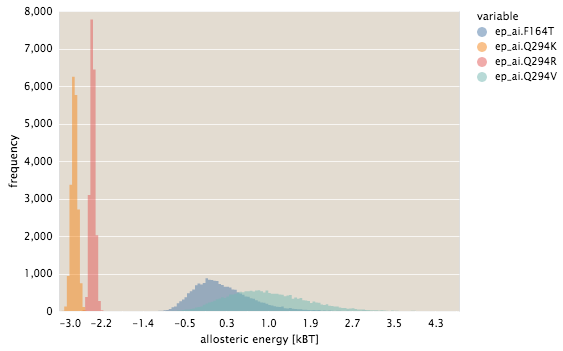

In [49]:
# Plot layered histograms. 
alt.data_transformers.enable('json')
alt.Chart(mcmc_df, config=pboc).mark_area(interpolate='step', opacity=0.5).encode(
    x=alt.X('value', bin=alt.Bin(maxbins=200), title='allosteric energy [kBT]'),
    y=alt.Y('count(value)', stack=None, title='frequency'), 
    color='variable').interactive()

In [50]:
# Compute the fits and plot. 
dfs = []
c_range = np.logspace(-2, 4, 500)
for m in idx_key.keys():
    # Isolate the parameters.
    ep_ai = samples_stats[samples_stats['parameter']=='ep_ai.{}'.format(m)]['mode'].values[0]
    ka = samples_stats[samples_stats['parameter']=='ka.{}'.format(m)]['mode'].values[0]
    ki = samples_stats[samples_stats['parameter']=='ki.{}'.format(m)]['mode'].values[0]
    
    # Compute the mode fit. 
    mode = mut.thermo.SimpleRepression(260, ops['O2'], ep_ai=ep_ai, ka=ka, ki=ki, 
                                       effector_conc=c_range).fold_change()
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        arch = mut.thermo.SimpleRepression(260, ops['O2'], ep_ai=samples_df['ep_ai.{}'.format(m)],
                                          ka=samples_df['ka.{}'.format(m)], 
                                          ki=samples_df['ki.{}'.format(m)],
                                          effector_conc=c).fold_change()
        cred_region[:, i] = mut.stats.compute_hpd(arch, 0.95)
        
    # Assemble the fit dataframe. 
    _df = pd.DataFrame(np.array([c_range, mode, cred_region[0, :], cred_region[1, :]]).T,
                       columns=['IPTGuM', 'mode', 'min', 'max'])
    _df['mutant'] = m
    dfs.append(_df)
fit_df = pd.concat(dfs) 

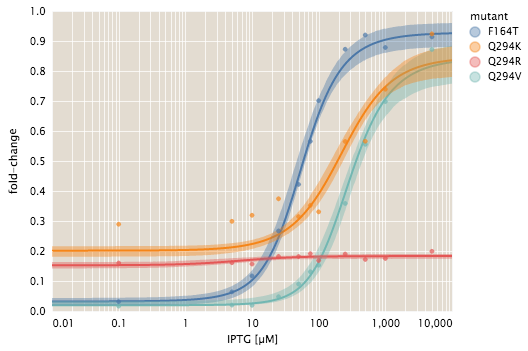

In [51]:
fits = alt.Chart(fit_df).mark_line().encode(
    x=alt.X('IPTGuM', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('mode', title='fold-change'), color='mutant')

points = alt.Chart(ind[ind['IPTGuM']!=0]).mark_circle(size=25).transform_aggregate(
    mean_c='mean(IPTGuM):Q', mean_fc='mean(fold_change):Q',
    groupby=['IPTGuM', 'mutant']).encode(
    x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('mean_fc:Q', title='fold-change'), color='mutant')
errors = alt.Chart(ind[ind['IPTGuM'] != 0]).mark_rule().transform_aggregate(
    mean_c='mean(IPTGuM):Q', mean_fc='mean(fold_change):Q',
    stderr='stderr(fold_change):Q', groupby=['IPTGuM', 'mutant']).transform_calculate(
    lower='datum.mean_fc - datum.stderr',
    upper='datum.mean_fc + datum.stderr').encode(
    x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('lower:Q', title='fold-change'), 
    y2='upper:Q',color='mutant')
ci = alt.Chart(fit_df).mark_area(opacity=0.4).encode(
    x=alt.X('IPTGuM:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('min:Q', title='fold-change'),
    y2='max:Q', color='mutant')
alt.layer(fits + ci + points, config=pboc).interactive()

In [52]:
# Compute the fits and plot. 
dfs = []
c_range = np.logspace(-2, 4, 500)
for m in idx_key.keys():
    # Isolate the parameters.
    ep_ai = samples_stats[samples_stats['parameter']=='ep_ai.{}'.format(m)]['mode'].values[0]
    ka = samples_stats[samples_stats['parameter']=='ka.{}'.format(m)]['mode'].values[0]
    ki = samples_stats[samples_stats['parameter']=='ki.{}'.format(m)]['mode'].values[0]
    
    # Compute the mode fit. 
    mode = mut.thermo.SimpleRepression(260, ops['O1'], ep_ai=ep_ai, ka=ka, ki=ki, 
                                       effector_conc=c_range).fold_change()
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):
        arch = mut.thermo.SimpleRepression(260, ops['O1'], ep_ai=samples_df['ep_ai.{}'.format(m)],
                                          ka=samples_df['ka.{}'.format(m)], 
                                          ki=samples_df['ki.{}'.format(m)],
                                          effector_conc=c).fold_change()
        cred_region[:, i] = mut.stats.compute_hpd(arch, 0.95)
        
    # Assemble the fit dataframe. 
    _df = pd.DataFrame(np.array([c_range, mode, cred_region[0, :], cred_region[1, :]]).T,
                       columns=['IPTGuM', 'mode', 'min', 'max'])
    _df['mutant'] = m
    dfs.append(_df)
pred_df = pd.concat(dfs) 

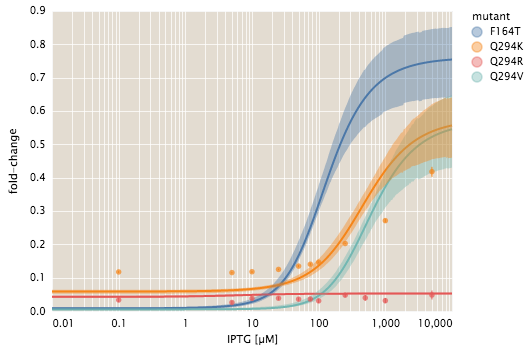

In [53]:
pred = alt.Chart(pred_df).mark_line().encode(
    x=alt.X('IPTGuM', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('mode', title='fold-change'), color='mutant')
ci = alt.Chart(pred_df).mark_area(opacity=0.4).encode(
    x=alt.X('IPTGuM:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('min:Q', title='fold-change'),
    y2='max:Q', color='mutant')
points = alt.Chart(data[(data['IPTGuM']!=0) & (data['class']=='IND')
    & (data['operator']=='O1')]).mark_circle(size=30).transform_aggregate(
    mean_c='mean(IPTGuM):Q', mean_fc='mean(fold_change):Q',
    groupby=['IPTGuM', 'mutant']).encode(
    x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('mean_fc:Q', title='fold-change'), color='mutant')

errors = alt.Chart(data[(data['IPTGuM']!=0) & (data['class']=='IND')
    & (data['operator']=='O1')]).mark_rule().transform_aggregate(
    mean_c='mean(IPTGuM):Q', mean_fc='mean(fold_change):Q',
    stderr='stderr(fold_change):Q', groupby=['IPTGuM', 'mutant']).transform_calculate(
    lower='datum.mean_fc - datum.stderr',
    upper='datum.mean_fc + datum.stderr').encode(
    x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('lower:Q', title='fold-change'), 
    y2='upper:Q',color='mutant')

alt.layer(pred + ci + points + errors, config=pboc)

# Fitting DNA binding energy 

In [69]:
# Isolate DNA mutants. 
dna = data[(data['class']=='DNA') & (data['operator']=='O2')]
dna = dna[dna['fold_change'] > 0]
wt_ka = 139
wt_ki = 0.53
leak = dna[dna['IPTGuM']==0].copy()
dna_idx = {m: i+1 for i, m in enumerate(dna['mutant'].unique())}
dna_idx_key = {dna_idx[j]:j for j in dna_idx}
for m in leak['mutant'].unique():
    leak.loc[leak['mutant']==m, 'idx'] = dna_idx[m]
leak['idx'] = leak['idx'].astype(int)

# Assemble the Data dictionary
data_dict = {'J':len(leak['mutant'].unique()), 'N':len(leak), 'idx':leak['idx'],
            'Nns':4.6E6, 'R':leak['repressors'], 'c':leak['IPTGuM'], 
            'ep_ai':4.5, 'fc':leak['fold_change']}

In [55]:
# Load the stan model.
dna_model = pystan.StanModel('../stan/DNA_binding_energy.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b48042d14f7f036d94071bd56dcc4312 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpgeirs62m/stanfit4anon_model_b48042d14f7f036d94071bd56dcc4312_6206625204721361241.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpgeirs62m/stanfit4anon_model_b48042d14f7f036d94071bd56dcc4312_6206625204721361241.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [70]:
# Sample the data and convert to a dataframe.
dna_samples = dna_model.sampling(data_dict, iter=5000, chains=4)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [71]:
dna_samples_df = mut.bayes.chains_to_dataframe(dna_samples)
rename = {}
for m in dna_samples_df.keys():
    if 'epR' in m:
        a, b = m.split('.')
        rename[m] = '{}.{}'.format(a, dna_idx_key[int(b)])
dna_samples_df.rename(columns=rename, inplace=True)
dna_stats = mut.stats.compute_statistics(dna_samples_df)

In [72]:
dna_samples

Inference for Stan model: anon_model_b48042d14f7f036d94071bd56dcc4312.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
epR[0]     -12.27  5.3e-4   0.05 -12.38 -12.31 -12.27 -12.24 -12.17  10000    1.0
epR[1]     -11.98  6.6e-4   0.07 -12.11 -12.02 -11.98 -11.93 -11.85  10000    1.0
epR[2]     -11.87  6.1e-4   0.06 -11.99 -11.91 -11.87 -11.83 -11.75  10000    1.0
sigma[0]     7.49  2.1e-3   0.21    7.1   7.35   7.48   7.63   7.92  10000    1.0
sigma[1]     7.65  2.5e-3   0.25   7.18   7.48   7.64   7.82   8.17  10000    1.0
sigma[2]     7.63  2.4e-3   0.24   7.18   7.46   7.63   7.78   8.11  10000    1.0
log_fc[0]   -4.43     0.0    0.0  -4.43  -4.43  -4.43  -4.43  -4.43      2    nan
log_fc[1]   -3.89     0.0    0.0  -3.89  -3.89  -3.89  -3.89  -3.89      2    nan
log_fc[2]   -0.27 3.9e-175.6e-17  -0.27  -0.27  -0.27  -0.27  -0.27     

In [66]:
# Compute the fits and plot.
dfs = []
c_range = np.logspace(-2, 4, 500)
for m in dna_idx.keys():
    # Isolate the parameters.
    epR = dna_stats[dna_stats['parameter']=='epR.{}'.format(m)]['mode'].values[0]    
    for r in dna['repressors'].unique(): 
        # Compute the mode fit. 
        mode = mut.thermo.SimpleRepression(r, epR, ep_ai=4.5, ka=wt_ka, ki=wt_ki, 
                                           effector_conc=c_range).fold_change()
        cred_region = np.zeros((2, len(c_range)))
        for i, c in enumerate(c_range):
            arch = mut.thermo.SimpleRepression(r, dna_samples_df['epR.{}'.format(m)], ep_ai=4.5,
                                              ka=wt_ka, 
                                              ki=wt_ki,
                                              effector_conc=c).fold_change()
            cred_region[:, i] = mut.stats.compute_hpd(arch, 0.95)
            
        # Assemble the fit dataframe. 
        _df = pd.DataFrame(np.array([c_range, mode, cred_region[0, :], cred_region[1, :]]).T,
                           columns=['IPTGuM', 'mode', 'min', 'max'])
        _df['mutant'] = m
        _df['repressors'] = r
        dfs.append(_df)
dna_fit_df = pd.concat(dfs) 

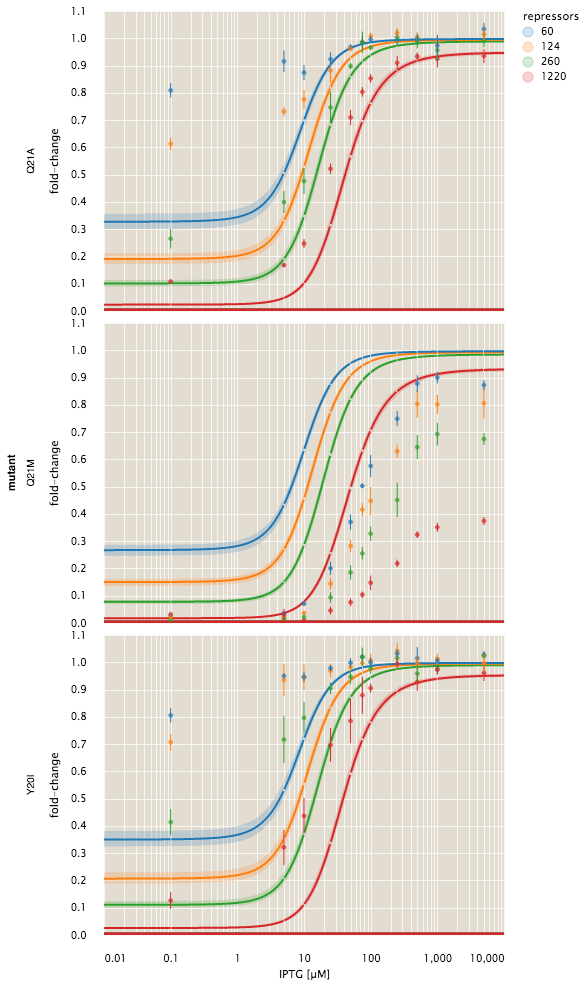

In [67]:
cmb = pd.concat([dna_fit_df, dna[dna['IPTGuM'] != 0]])
fits = alt.Chart().mark_line().encode(
    x=alt.X('IPTGuM', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('mode', title='fold-change'),
   color=alt.Color('repressors:N', scale={'scheme':'category10'}))
ci = alt.Chart().mark_area(opacity=0.2).encode(
    x=alt.X('IPTGuM', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('min', title='fold-change'),
    y2=alt.Y('max'),
    color=alt.Color('repressors:N', scale={'scheme':'category10'}))

points = alt.Chart().mark_circle(size=25).transform_aggregate(
    mean_c='mean(IPTGuM):Q', mean_fc='mean(fold_change):Q',
    groupby=['IPTGuM', 'repressors', 'mutant']).encode(
    x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('mean_fc:Q', title='fold-change'), color=alt.Color('repressors:N', scale={'scheme':'category10'}))
errors = alt.Chart().mark_rule().transform_aggregate(
    mean_c='mean(IPTGuM):Q', mean_fc='mean(fold_change):Q',
    stderr='stderr(fold_change):Q', groupby=['IPTGuM', 'repressors', 'mutant']).transform_calculate(
    lower='datum.mean_fc - datum.stderr',
    upper='datum.mean_fc + datum.stderr').encode(
    x=alt.X('mean_c:Q', title='IPTG [µM]', scale={'type':'log'}),
    y=alt.Y('lower:Q', title='fold-change'), 
    y2='upper:Q',color=alt.Color('repressors:N', scale={'scheme':'category10'}))

combined = ci + fits + points + errors

f1 = combined.facet("mutant:N", data=cmb, config=pboc).interactive()
# f2 = combined2.facet("mutant:N", data=dna[dna['IPTGuM'] != 0])
# alt.layer(f1 + f2, data=pd.concat([dna_fit_df, dna[dna['IPTGuM'] != 0]]))
f1

In [68]:
dna

,IPTGuM,date,fold_change,mutant,operator,repressors,username,class,method
72,0.0,20180213,0.011940,Q21M,O2,260.0,gchure,DNA,flow cytometry
74,0.0,20180213,0.020366,Q21M,O2,124.0,gchure,DNA,flow cytometry
78,0.1,20180213,0.001042,Q21M,O2,260.0,gchure,DNA,flow cytometry
81,0.1,20180213,0.007875,Q21M,O2,60.0,gchure,DNA,flow cytometry
82,5.0,20180213,0.048446,Q21M,O2,60.0,gchure,DNA,flow cytometry
85,5.0,20180213,0.021070,Q21M,O2,124.0,gchure,DNA,flow cytometry
86,5.0,20180213,0.018796,Q21M,O2,260.0,gchure,DNA,flow cytometry
87,10.0,20180213,0.092397,Q21M,O2,60.0,gchure,DNA,flow cytometry
88,10.0,20180213,0.047540,Q21M,O2,124.0,gchure,DNA,flow cytometry
90,10.0,20180213,0.010539,Q21M,O2,1220.0,gchure,DNA,flow cytometry
